In [1]:
# Importing necessary packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing
import warnings
from sklearn.model_selection import train_test_split
from pylab import rcParams
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import LSTM
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
df1=pd.read_excel("C:/Users/user/Atul Sir's Project/YTD 2018 _EWH_Jan18 to Oct18.xlsx",index_col=None) # info of EWH from Jan2018 to oct2018
df2=pd.read_excel("C:/Users/user/Atul Sir's Project/YTD 2018 _EWH_Nov18 to Dec18.xlsx",index_col=None) # info of EWH from Nov2018 to Dec2018

In [3]:
df_2018=pd.concat([df1,df2],ignore_index=True)

In [4]:
# This will remove space,underscores from column names
df_2018.columns = df_2018.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [5]:
df_2018.shape

(38214, 76)

In [6]:
# Setting Datatime index
df_2018['invoice_da']=pd.to_datetime(df_2018['invoice_da'],format='%d.%m.%Y')
df_2018=df_2018.set_index('invoice_da')

In [7]:
df_2018.head() 

,plant,material,material_description,quantity,ph3,ph,sales_zone,zone,item_categ,po_no.,...,amount,order_type,lst_number,insurance.1,gr_-_good,amount.1,ec_%,pstg_date,discount_%,delivery_-
invoice_da,,,,,,,,,,,,,,,,,,,,,
2018-04-04,IM,3801879,PRONTO NEO SS 3V- 4.5KW IV,8,Other,INSTANT,INMUM,Mumbai,ZOS,M-17/03767,...,0,ZOS - ATG standard order,27740039796,0,NOT FOUND,0,0,NOT FOUND,0,8270185
2018-04-04,IM,3802969,CDR SP 35HL 2KW WH -4S,1,Other,CDR/CDP,INMUM,Mumbai,ZOS,M-17/03767,...,0,ZOS - ATG standard order,27740039796,0,NOT FOUND,0,0,NOT FOUND,0,8270185
2018-04-04,IM,3803001,CDR SP 15H 2KW WH-N,10,Other,CDR/CDP,INMUM,Mumbai,ZOS,M-17/03767,...,0,ZOS - ATG standard order,27740039796,0,NOT FOUND,0,0,NOT FOUND,0,8270185
2018-04-04,IM,3803003,CDR SP 15HL 2KW WH-N,1,Other,CDR/CDP,INMUM,Mumbai,ZOS,M-17/03767,...,0,ZOS - ATG standard order,27740039796,0,NOT FOUND,0,0,NOT FOUND,0,8270185
2018-04-04,IM,3803012,CDR SP 10H 2KW WH-N,2,Other,CDR/CDP,INMUM,Mumbai,ZOS,M-17/03767,...,0,ZOS - ATG standard order,27740039796,0,NOT FOUND,0,0,NOT FOUND,0,8270185


In [8]:
# Data visualization
%matplotlib inline

In [9]:
df_2018=df_2018.sort_index(ascending=True) # This will sort our index as per asending order

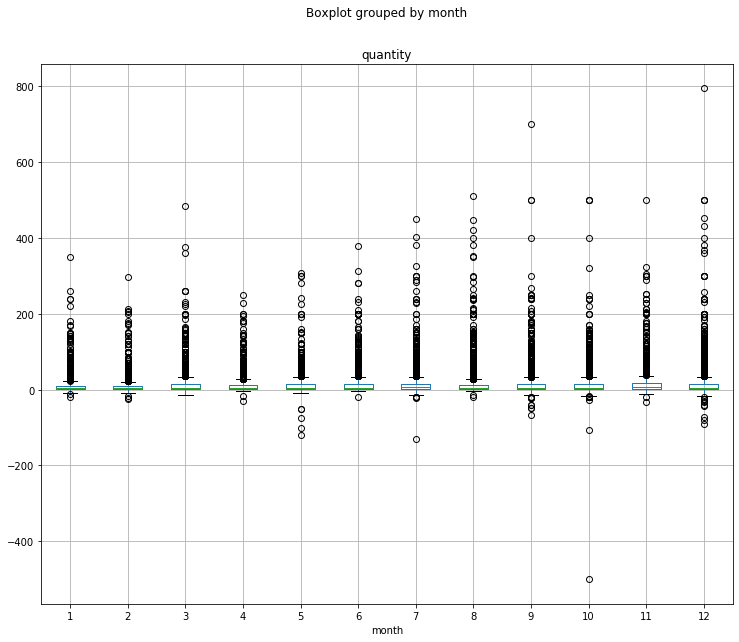

In [10]:
df_2018.boxplot(column="quantity",by='month',figsize=(12,10)); #Delete row with quantity value less than 0

#### From above chart we can see there on some days sales quantity were in negative

In [11]:
# Dates with negative sales quantity
df_2018.index[df_2018['quantity']<0].unique()

DatetimeIndex(['2018-01-04', '2018-01-05', '2018-01-08', '2018-01-10',
               '2018-01-11', '2018-01-13', '2018-01-16', '2018-02-08',
               '2018-02-13', '2018-02-16',
               ...
               '2018-12-15', '2018-12-17', '2018-12-18', '2018-12-20',
               '2018-12-21', '2018-12-22', '2018-12-24', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='invoice_da', length=106, freq=None)

In [12]:
# print the columns with nan value
print([df_2018.columns[i] for i in range(len(df_2018.columns)) if (df_2018.iloc[:,i].isna().any(axis=0))==True])

['po_no.', 'po_date', 'cost_cente', 'lr_number', 'transporte', 'state', 'cust_grp', 'customer_g', 'lst_number']


In [13]:
# Fillna(0)
df_2018=df_2018.fillna(0)

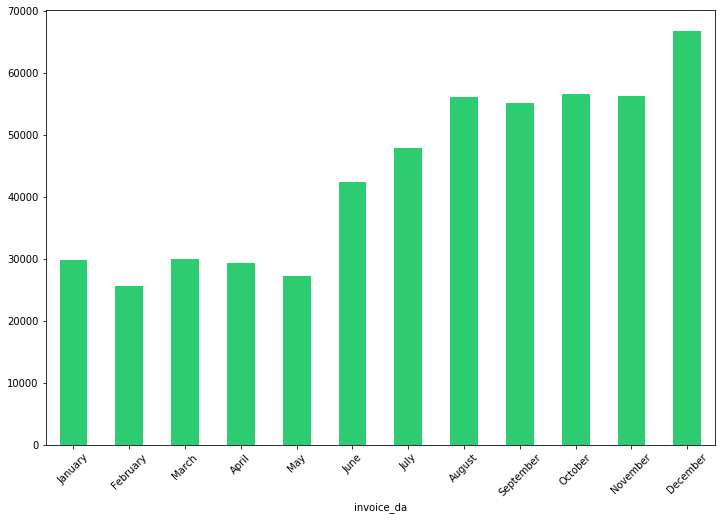

In [14]:
# Monthly sales 
df_monthly=df_2018.resample('M').sum()
def line_format(label):
    month=label.month_name()
    if month == 'Jan':
        month += f'\n{label}'
    return month

ax=df_2018.quantity.resample('M').sum().plot(kind='bar', figsize=(12, 8), color='#2ecc71', rot=45)
ax.set_xticklabels(map(lambda x: line_format(x), df_monthly.index));

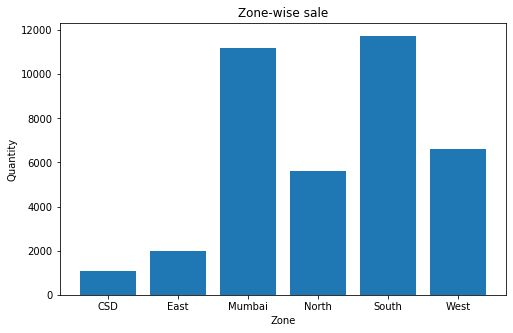

In [15]:
# Zonwise sales
rcParams['figure.figsize']=8,5
ax1=df_2018[['quantity','zone']].groupby('zone',as_index=False).count()
plt.bar(ax1.zone,ax1.quantity)
plt.xlabel("Zone")
plt.ylabel("Quantity")
plt.title("Zone-wise sale")
plt.show();

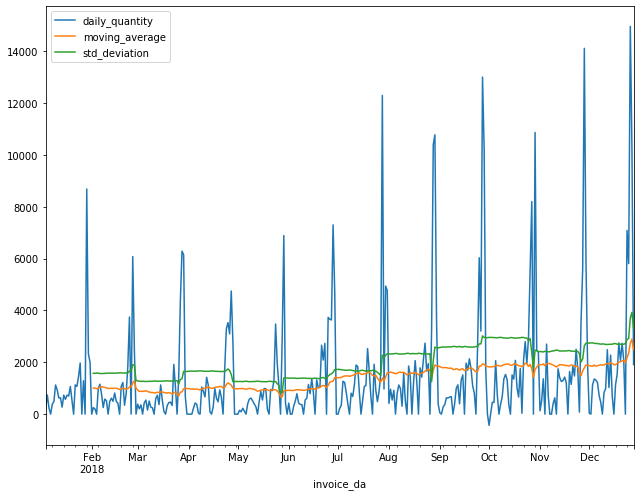

In [16]:
df=pd.DataFrame()
df['daily_quantity']=df_2018['quantity'].resample('D').sum()
df['moving_average']=df['daily_quantity'].rolling(window=30).mean()
df['std_deviation']=df['daily_quantity'].rolling(window=30).std()

plt.figure(figsize=(9,7))
df['daily_quantity'].plot();
df['moving_average'].plot();
df['std_deviation'].plot();
plt.tight_layout();
plt.legend(loc=2);

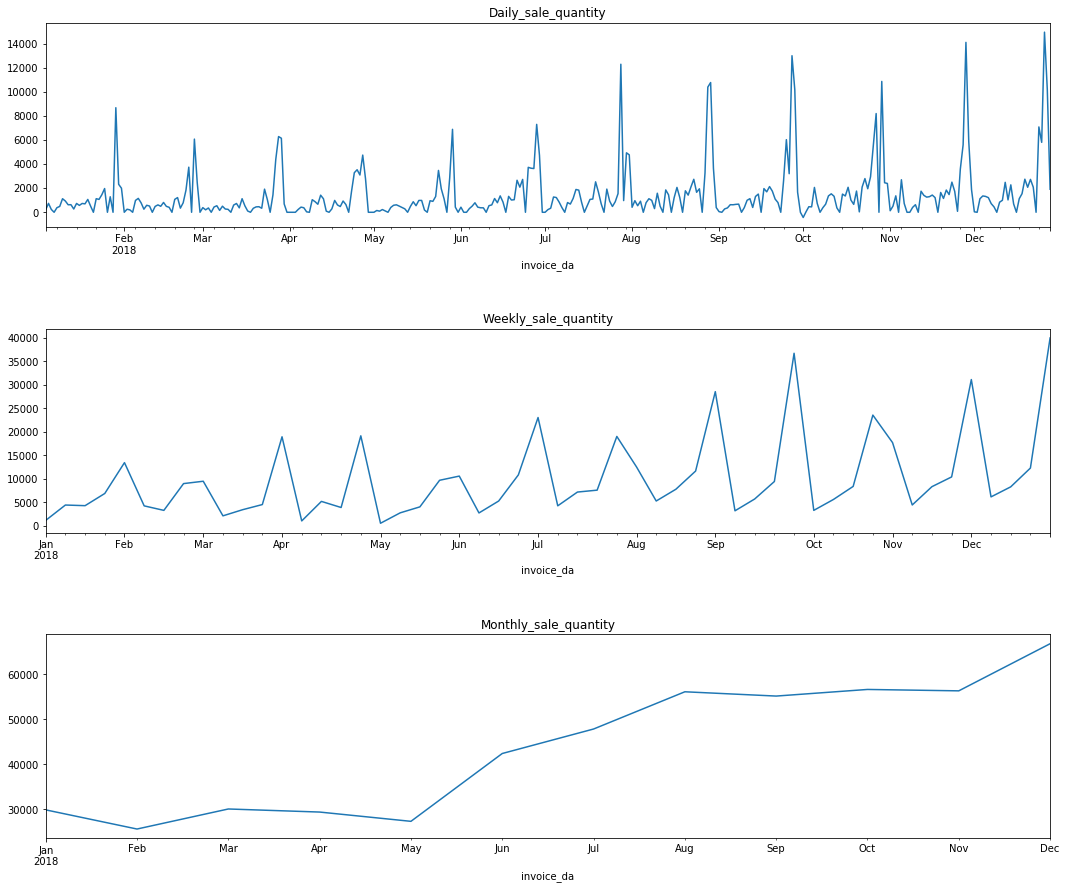

In [17]:
# Visulaizing sales data on daily,weekly and monthly basis
fig=plt.figure(figsize=(18,15))

fig.subplots_adjust(hspace=0.5)

ax1=fig.add_subplot(3,1,1)
ax1= df_2018['quantity'].resample('D').sum()
ax1=ax1.fillna(value=0)
ax1.plot(title='Daily_sale_quantity');

ax2=fig.add_subplot(3,1,2)
ax2= df_2018['quantity'].resample('W').sum()
ax2.plot(title='Weekly_sale_quantity');

ax3=fig.add_subplot(3,1,3)
ax3= df_2018['quantity'].resample('M').sum()
ax3.plot(title='Monthly_sale_quantity');

In [18]:
df_weekly=pd.DataFrame()
df_weekly['weekly']=df_2018.quantity.resample('W').sum()

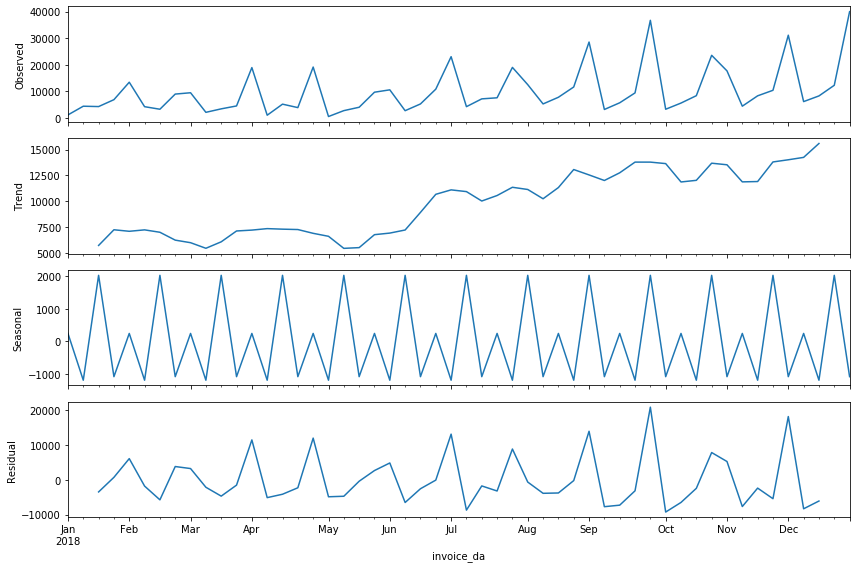

In [19]:
rcParams['figure.figsize']=12,8
result_weekly=seasonal_decompose(df_weekly['weekly'],model='Additive',freq=4) # As sasonality patern every after 4 weeks
result_weekly.plot();

## Forecasting using SARIMA

In [20]:
# Make train test split
train_sarima=df_weekly.iloc[:44]
test_sarima=df_weekly.iloc[44:]

In [21]:
# Check stationarity in data by running Augumented dickey fuller test
from statsmodels.tsa.stattools import adfuller #Before running adfuller import it from library
def adf_test(series):
    result=adfuller(series)
    list1=['ADF test statistic','p-value','# lags used','# observations']
    out=pd.Series(result[0:4],index=list1)
    for key,val in result[4].items(): # this will unpack kay value pair from tuple
        out[key]=val
    print(out.to_string()) # This will print pandas series to string 
    
    if out.iloc[1] <=0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [22]:
adf_test(df_weekly.weekly) # From below we can say data is non sationary

ADF test statistic     0.253696
p-value                0.975117
# lags used            9.000000
# observations        42.000000
1%                    -3.596636
5%                    -2.933297
10%                   -2.604991
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [23]:
# Model the data using SARIMA
auto_arima(df_weekly.weekly,seasonal=True,m=13).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   52
Model:             SARIMAX(2, 0, 2)x(0, 1, 0, 13)   Log Likelihood                -380.173
Date:                            Wed, 04 Dec 2019   AIC                            772.346
Time:                                    13:34:02   BIC                            782.328
Sample:                                         0   HQIC                           775.927
                                             - 52                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3097.6595   1068.210      2.900      0.004    1004.005    5191.314
ar.L1          0.4233      0.195      2.173      0.030       0.041       0.805
ar.L2         -0.7139      0.173     -4.129      0.000      -1.053      -0.375
ma.L1         -0.8389      0.195     -4.291      0.000      -1.222      -0.456
ma.L2          0.9900      0.304      3.256      0.001       0.394       1.586
sigma2      1.758e+07      0.010   1.76e+09      0.000    1.76e+07    1.76e+07
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 2.88
Prob(Q):                               nan   Prob(JB):                         0.24
Heteroskedasticity (H):               0.26   Skew:                            -0.04
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.77e+25. Standard errors may be unstable.
"""

In [24]:
# Fit model on train set
model_sarima=SARIMAX(train_sarima.weekly,order=(2,0,2),seasonal_order=(0,1,0,13))
result_sarima=model_sarima.fit()

In [25]:
# Prediction 
start=len(train_sarima)
end=len(train_sarima)+len(test_sarima)-1
prediction_sarima=result_sarima.predict(start=start,end=end,type='Levels')

In [26]:
# Compare predcted value with test set
for i in range(0,len(test_sarima)):
    print ("prediction {}, Expected value {}".format(prediction_sarima[i],test_sarima['weekly'].iloc[i]))

prediction 9992.713295465406, Expected value 4465
prediction 8200.945667671564, Expected value 8354
prediction 16353.889143875698, Expected value 10426
prediction 28928.768324527777, Expected value 31110
prediction 7910.0653080469365, Expected value 6184
prediction 6127.590665683932, Expected value 8315
prediction 14132.241787858049, Expected value 12308
prediction 37087.412691261095, Expected value 39953


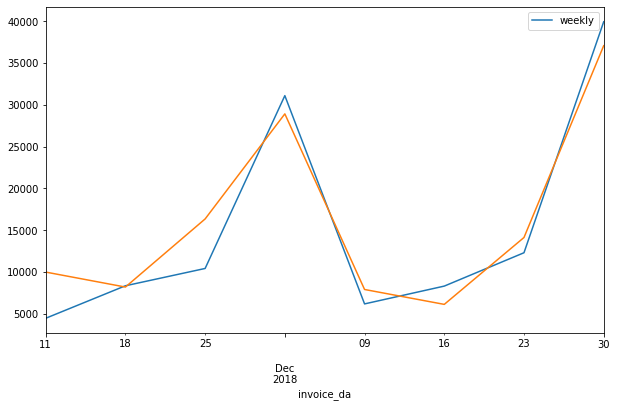

In [27]:
# Plot results of test and prediction
rcParams['figure.figsize']=10,6
prediction_sarima=prediction_sarima.rename('Prediction')
test_sarima.weekly.plot(legend=True);
prediction_sarima.plot();

In [28]:
# Model Evaluation

In [29]:
def rmlse(originaldata,predicteddata):
    error=np.square(np.log10(originaldata)-np.log10(predicteddata)).mean()**0.5
    acc=1-error
    return (acc*100)

In [30]:
rmse(test_sarima['weekly'],prediction_sarima)

3350.003563388804

In [31]:
mean_absolute_error(test_sarima.weekly,prediction_sarima)

2799.1490232627157

In [32]:
rmlse(test_sarima.weekly,prediction_sarima)

84.37393827404247

In [33]:
# We will see coorelation between error obtain during prediction
# 1. No coorelation means no pattern left in data]
# 2. If coorelation exist means some pttern left in data

In [34]:
def error_corr(label1,label2):
    error=pd.DataFrame()
    error['Y_true']=label1
    error['Y_predicted']=label2
    error['error']=error['Y_true']-error['Y_predicted']
    return sns.scatterplot(x=range(1,len(error.error)+1),y=error.error);

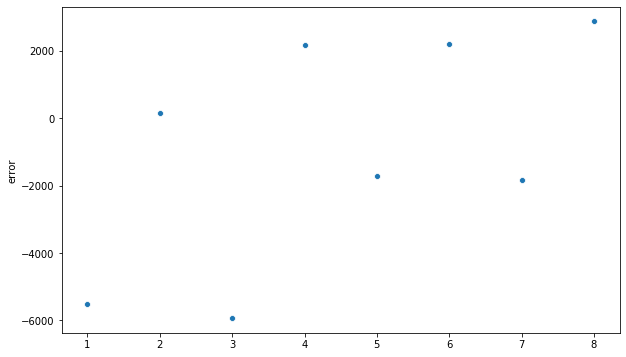

In [35]:
# Corelation between error
error_corr(test_sarima.weekly,prediction_sarima);

In [36]:
# Model Forecasting

In [37]:
model2=SARIMAX(df_weekly.weekly,order=(2,0,2),seasonal_order=(0,1,0,13))
result2=model2.fit()

In [38]:
forecast=result2.predict(start=len(df_weekly)-1,end=len(df_weekly)+7,typ='levels')

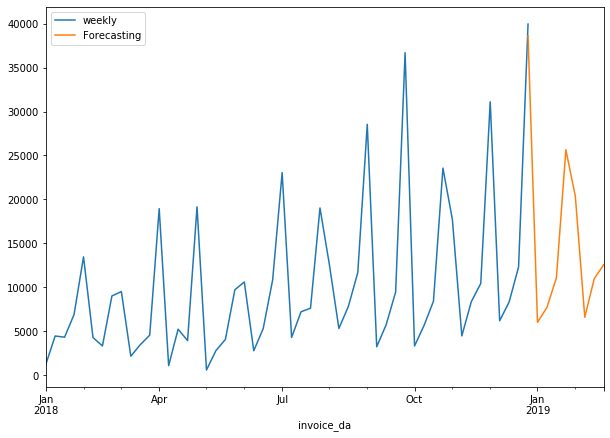

In [39]:
rcParams['figure.figsize']=10,7
forecast=forecast.rename('Forecasting')
df_weekly.plot(legend=True);
forecast.plot(legend=True);

## Forecasting using Holtwinter's method

In [39]:
# Make train test split
train_hw=df_weekly.iloc[:44]
test_hw=df_weekly.iloc[44:]

In [40]:
model_hw=ExponentialSmoothing(train_hw['weekly'],trend='add',seasonal='add',seasonal_periods=13).fit(0.1,0.1,1)

In [41]:
forecast_hw=model_hw.forecast(len(test_hw))

In [42]:
forecast_hw.rename('Prediction',inplace=True)

2018-11-11     7724.662874
2018-11-18    10288.010182
2018-11-25    14114.900245
2018-12-02    31163.886519
2018-12-09     4288.572687
2018-12-16     7195.329457
2018-12-23    11329.905954
2018-12-30    39198.155586
Freq: W-SUN, Name: Prediction, dtype: float64

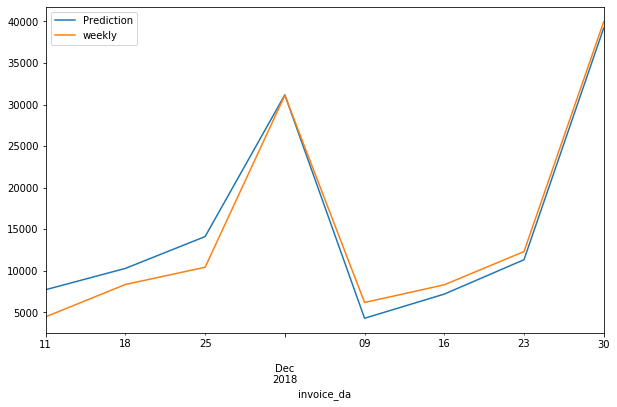

In [43]:
forecast_hw.plot(legend=True)
test_hw.weekly.plot(legend=True);

In [44]:
# Evaluating model on test data

In [45]:
rmse(test_hw.weekly,forecast_hw)

2072.120022104154

In [46]:
mean_absolute_error(test_hw.weekly,forecast_hw)

1710.5620170672448

In [47]:
rmlse(test_hw.weekly,forecast_hw)

88.12916079950259

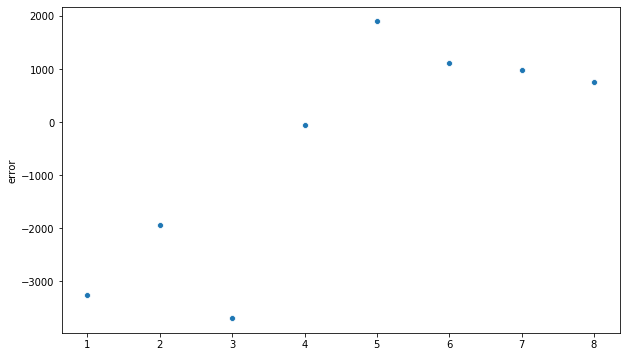

In [48]:
error_corr(test_hw.weekly,forecast_hw);

In [49]:
# Evaluating model on complete data and then forcasting for future months

In [50]:
model_fin=ExponentialSmoothing(df_weekly['weekly'],trend='add',seasonal='add',seasonal_periods=13).fit(0.1,0.1,1)

In [51]:
forecast_fin=model_fin.forecast(8)

In [52]:
forecast_fin=forecast_fin.rename('Prediction_2019')

In [53]:
# Visualizing the plot

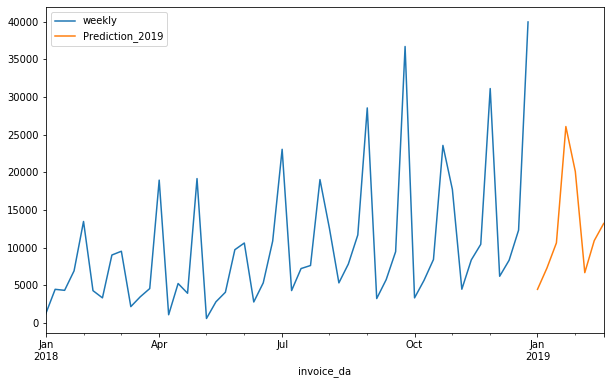

In [54]:
df_weekly['weekly'].plot(legend=True);
forecast_fin.plot(legend=True);

## Forecasting using XG boost

In [55]:
def features(dataframe,label):
    """
    This creates multiple feature and store in X
    """
    dataframe['week'] = dataframe.index.week
    dataframe['day']=dataframe.index.day
    dataframe['month'] = dataframe.index.month
    
    X = dataframe[['week','day','month']]
    return X

In [56]:
X1=features(df_weekly,df_weekly['weekly'])
Y1=df_weekly['weekly']

In [57]:
X_train,X_test,Y_train,Y_test=train_test_split(X1,Y1,test_size=0.15,shuffle=False)

In [58]:
model_xg=XGBRegressor(n_estimators=1000,max_depth=8,learning_rate=0.1,reg_lambda=1,subsample=0.8)

In [59]:
model_xg.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_test,Y_test)],early_stopping_rounds=50,verbose=False)

[13:39:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [60]:
pred_xgb=model_xg.predict(X_test)

In [61]:
pred_xgb=pd.Series(pred_xgb)
Y_test=pd.Series([i for i in Y_test])

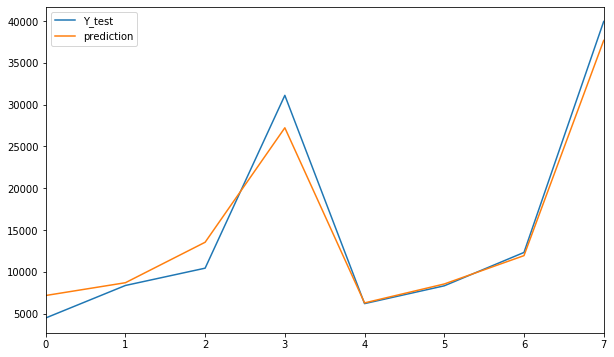

In [62]:
predict=pd.DataFrame()
predict=pd.DataFrame(data={'Y_test':Y_test,'prediction':pred_xgb})
predict.plot();

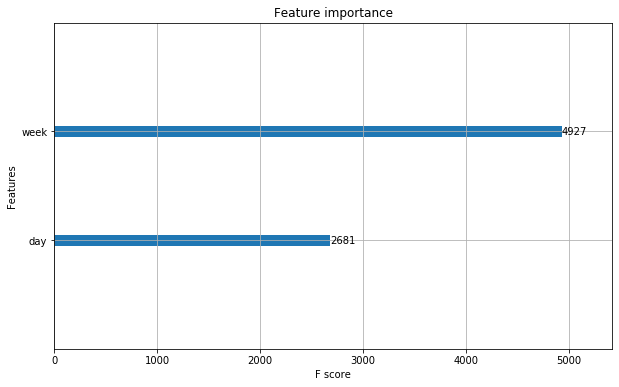

In [63]:
a=plot_importance(model_xg,height=0.1)

In [64]:
# Evaluation metrics

In [65]:
rmse(predict.Y_test,predict.prediction)

2162.075502322362

In [66]:
mean_absolute_error(predict.Y_test,predict.prediction)

1619.9461669921875

In [67]:
rmlse(predict.Y_test,predict.prediction)

91.38658352171012

In [68]:
# Error evaluation

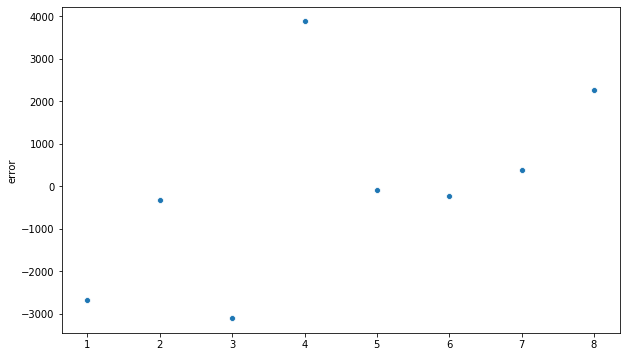

In [69]:
error_corr(predict.Y_test,predict.prediction);

## Forecasting using LSTM

In [70]:
df_lstm=pd.DataFrame()
df_lstm['weekly']=df_2018.quantity.resample('W').sum()

In [71]:
# Making train test split
train_lstm= df_lstm[:40]
test_lstm= df_lstm[40:]

In [72]:
def split_data(data,no_inputs):
    ''' This will make split 
    X=[[1,2,3,4,5]]-->Y=[6]                                                                                                                  
    So we take X=[1,2,3,4,5] and y=[6]'''
    X,Y=[],[]
    for i in range(len(data)-no_inputs):
        a= data[i:i+no_inputs,0]
        b= data[i+no_inputs,0]
        X.append(a)
        Y.append(b)
    return np.array(X),np.array(Y)

In [73]:
# Scaling the data
scaler=MinMaxScaler()
scaler.fit(train_lstm)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [74]:
#Transforming the data
train_scaled=scaler.transform(train_lstm)
test_scaled=scaler.transform(test_lstm)

In [75]:
# making a tranin test split 
no_inputs=4
train_X,train_Y=split_data(train_scaled,no_inputs)
test_X,test_Y=split_data(test_scaled,no_inputs)

In [76]:
# Reshaping data in 3D as LSTM accept tensor data
train_X=np.reshape(train_X,(train_X.shape[0],train_X.shape[1],1)) # 3D array (no_inputs,time_steps,No_features)
test_X=np.reshape(test_X,(test_X.shape[0],test_X.shape[1],1))

In [77]:
test_X.shape

(8, 4, 1)

In [78]:
model_lstm=Sequential()

model_lstm.add(LSTM(40,activation='relu',input_shape=(train_X.shape[1],1))) # adding LSTM layer 

model_lstm.add(Dense(1)) # No of neuron in output layer

model_lstm.compile(optimizer='adam',loss='mse')

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40)                6720      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________


In [79]:
epochs=700
model_lstm.fit(train_X,train_Y,epochs=epochs,batch_size=1,verbose=False)

In [80]:
loss_val=model_lstm.history.history['loss']

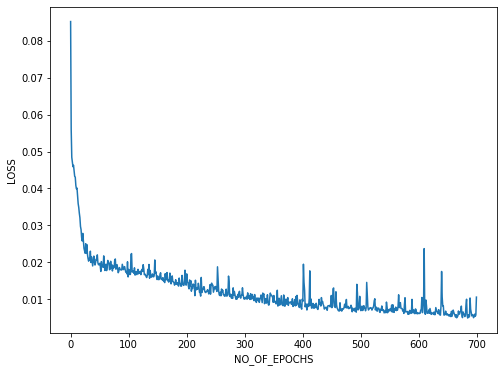

In [81]:
from pylab import rcParams
rcParams['figure.figsize']=8,6
plt.plot(range(epochs),loss_val)
plt.xlabel('NO_OF_EPOCHS');
plt.ylabel('LOSS');

In [82]:
# Making prediction
prediction_lstm=model_lstm.predict(test_X)

In [83]:
# Transforming scaled data to original
prediction_lstm=scaler.inverse_transform(prediction_lstm)

In [84]:
# Predicted data is flatten up so that we can append to dataframe
prediction_lstm=prediction_lstm.flatten()

In [85]:
lstm=pd.DataFrame()
index=len(test_scaled)-no_inputs
lstm['test_Y']=test_lstm.weekly.iloc[-index:].tolist()
lstm['prediction']=prediction_lstm

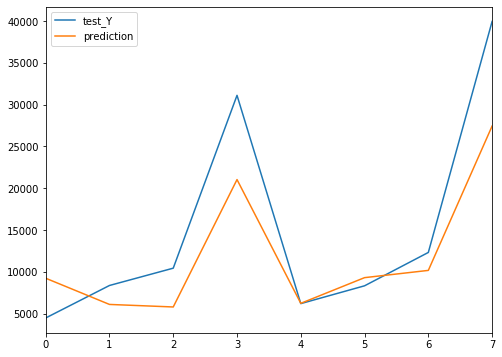

In [93]:
lstm.plot();

In [94]:
rmse(lstm.test_Y,lstm.prediction)

6257.8353354379315

In [95]:
mean_absolute_error(lstm.test_Y,lstm.prediction)

4678.619812011719

In [96]:
rmlse(lstm.test_Y,lstm.prediction)

82.37370930819404

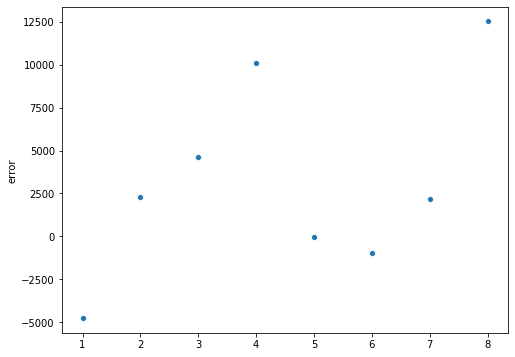

In [97]:
error_corr(lstm.test_Y,lstm.prediction);